### First approach

In [2]:
import os

os.chdir("/home/adamczykb/rnaquanet/src")

In [3]:
import torch
import torch.nn as nn
from rnaquanet.dataset.RNAQuANetDataset import RNAQuANetDataset
from rnaquanet.dataset.RNAQuANetDataset import RNAQuANetDatasetSubset

from torch_geometric import nn as gnn
import lightning as L
from torch_geometric.loader import DataLoader
from numpy import inf


In [5]:
from typing import Optional

import torch.nn.functional as F

from torch_geometric.nn.conv import GCNConv
from torch_geometric.utils import to_dense_batch
from typing import Optional

import torch
from torch import Tensor


class SGFormerAttention(torch.nn.Module):
    r"""The simple global attention mechanism from the
    `"SGFormer: Simplifying and Empowering Transformers for
    Large-Graph Representations"
    <https://arxiv.org/abs/2306.10759>`_ paper.

    Args:
        channels (int): Size of each input sample.
        heads (int, optional): Number of parallel attention heads.
            (default: :obj:`1.`)
        head_channels (int, optional): Size of each attention head.
            (default: :obj:`64.`)
        qkv_bias (bool, optional): If specified, add bias to query, key
            and value in the self attention. (default: :obj:`False`)
    """
    def __init__(
        self,
        channels: int,
        heads: int = 1,
        head_channels: int = 64,
        qkv_bias: bool = False,
    ) -> None:
        super().__init__()
        assert channels % heads == 0
        assert heads == 1, 'The number of heads are fixed as 1.'
        if head_channels is None:
            head_channels = channels // heads

        self.heads = heads
        self.head_channels = head_channels

        inner_channels = head_channels * heads
        self.q = torch.nn.Linear(channels, inner_channels, bias=qkv_bias)
        self.k = torch.nn.Linear(channels, inner_channels, bias=qkv_bias)
        self.v = torch.nn.Linear(channels, inner_channels, bias=qkv_bias)

    def forward(self, x: Tensor, mask: Optional[Tensor] = None) -> Tensor:
        r"""Forward pass.

        Args:
            x (torch.Tensor): Node feature tensor
                :math:`\mathbf{X} \in \mathbb{R}^{B \times N \times F}`, with
                batch-size :math:`B`, (maximum) number of nodes :math:`N` for
                each graph, and feature dimension :math:`F`.
            mask (torch.Tensor, optional): Mask matrix
                :math:`\mathbf{M} \in {\{ 0, 1 \}}^{B \times N}` indicating
                the valid nodes for each graph. (default: :obj:`None`)
        """
        B, N, *_ = x.shape
        qs, ks, vs = self.q(x), self.k(x), self.v(x)
        # reshape and permute q, k and v to proper shape
        # (b, n, num_heads * head_channels) to (b, n, num_heads, head_channels)
        qs, ks, vs = map(
            lambda t: t.reshape(B, N, self.heads, self.head_channels),
            (qs, ks, vs))

        if mask is not None:
            mask = mask[:, :, None, None]
            vs.masked_fill_(~mask, 0.)
        # replace 0's with epsilon
        epsilon = 1e-6
        qs[qs == 0] = epsilon
        ks[ks == 0] = epsilon
        # normalize input, shape not changed
        qs, ks = map(
            lambda t: t / torch.linalg.norm(t, ord=2, dim=-1, keepdim=True),
            (qs, ks))

        # numerator
        kvs = torch.einsum("blhm,blhd->bhmd", ks, vs)
        attention_num = torch.einsum("bnhm,bhmd->bnhd", qs, kvs)
        attention_num += N * vs

        # denominator
        all_ones = torch.ones([B, N]).to(ks.device)
        ks_sum = torch.einsum("blhm,bl->bhm", ks, all_ones)
        attention_normalizer = torch.einsum("bnhm,bhm->bnh", qs, ks_sum)
        # attentive aggregated results
        attention_normalizer = torch.unsqueeze(attention_normalizer,
                                               len(attention_normalizer.shape))
        attention_normalizer += torch.ones_like(attention_normalizer) * N
        attn_output = attention_num / attention_normalizer

        return attn_output.mean(dim=2)

    def reset_parameters(self):
        self.q.reset_parameters()
        self.k.reset_parameters()
        self.v.reset_parameters()

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'heads={self.heads}, '
                f'head_channels={self.head_channels})')

class GraphModule(torch.nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_channels,
        num_layers=2,
        dropout=0.5,
    ):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        self.fcs = torch.nn.ModuleList()
        self.fcs.append(torch.nn.Linear(in_channels, hidden_channels))

        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

        self.dropout = dropout
        self.activation = F.relu

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()
        for fc in self.fcs:
            fc.reset_parameters()

    def forward(self, x, edge_index):
        x = self.fcs[0](x)
        x = self.bns[0](x)
        x = self.activation(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        last_x = x

        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = self.bns[i + 1](x)
            x = self.activation(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = x + last_x
        return x


class SGModule(torch.nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_channels,
        num_layers=2,
        num_heads=1,
        dropout=0.5,
    ):
        super().__init__()

        self.attns = torch.nn.ModuleList()
        self.fcs = torch.nn.ModuleList()
        self.fcs.append(torch.nn.Linear(in_channels, hidden_channels))
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.LayerNorm(hidden_channels))
        for _ in range(num_layers):
            self.attns.append(
                SGFormerAttention(hidden_channels, num_heads, hidden_channels))
            self.bns.append(torch.nn.LayerNorm(hidden_channels))

        self.dropout = dropout
        self.activation = F.relu

    def reset_parameters(self):
        for attn in self.attns:
            attn.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()
        for fc in self.fcs:
            fc.reset_parameters()

    def forward(self, x: Tensor, batch: Tensor):
        # to dense batch expects sorted batch
        batch, indices = batch.sort(stable=True)
        x = x[indices]
        x, mask = to_dense_batch(x, batch)
        layer_ = []

        # input MLP layer
        x = self.fcs[0](x)
        x = self.bns[0](x)
        x = self.activation(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # store as residual link
        layer_.append(x)

        for i, attn in enumerate(self.attns):
            x = attn(x, mask)
            x = (x + layer_[i]) / 2.
            x = self.bns[i + 1](x)
            x = self.activation(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            layer_.append(x)

        x_mask = x[mask]
        # reverse the sorting
        unsorted_x_mask = x_mask[indices.argsort()]
        return unsorted_x_mask

class SGFormer(torch.nn.Module):
    r"""The sgformer module from the
    `"SGFormer: Simplifying and Empowering Transformers for
    Large-Graph Representations"
    <https://arxiv.org/abs/2306.10759>`_ paper.

    Args:
        in_channels (int): Input channels.
        hidden_channels (int): Hidden channels.
        out_channels (int): Output channels.
        trans_num_layers (int): The number of layers for all-pair attention.
            (default: :obj:`2`)
        trans_num_heads (int): The number of heads for attention.
            (default: :obj:`1`)
        trans_dropout (float): Global dropout rate.
            (default: :obj:`0.5`)
        gnn_num_layers (int): The number of layers for GNN.
            (default: :obj:`3`)
        gnn_dropout (float): GNN dropout rate.
            (default: :obj:`0.5`)
        graph_weight (float): The weight balance global and gnn module.
            (default: :obj:`0.5`)
        aggregate (str): Aggregate type.
            (default: :obj:`add`)
    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        trans_num_layers: int = 2,
        trans_num_heads: int = 1,
        trans_dropout: float = 0.5,
        gnn_num_layers: int = 3,
        gnn_dropout: float = 0.5,
        graph_weight: float = 0.5,
        aggregate: str = 'add',
    ):
        super().__init__()
        self.trans_conv = SGModule(
            in_channels,
            hidden_channels,
            trans_num_layers,
            trans_num_heads,
            trans_dropout,
        )
        self.graph_conv = GraphModule(
            in_channels,
            hidden_channels,
            gnn_num_layers,
            gnn_dropout,
        )
        self.graph_weight = graph_weight

        self.aggregate = aggregate

        if aggregate == 'add':
            self.fc = torch.nn.Linear(hidden_channels, out_channels)
        elif aggregate == 'cat':
            self.fc = torch.nn.Linear(2 * hidden_channels, out_channels)
        else:
            raise ValueError(f'Invalid aggregate type:{aggregate}')

        self.params1 = list(self.trans_conv.parameters())
        self.params2 = list(self.graph_conv.parameters())
        self.params2.extend(list(self.fc.parameters()))

    def reset_parameters(self) -> None:
        self.trans_conv.reset_parameters()
        self.graph_conv.reset_parameters()
        self.fc.reset_parameters()


    def forward(
        self,
        x: Tensor,
        edge_index: Tensor,
        batch: Optional[Tensor],
    ) -> Tensor:
        r"""Forward pass.

        Args:
            x (torch.Tensor): The input node features.
            edge_index (torch.Tensor or SparseTensor): The edge indices.
            batch (torch.Tensor, optional): The batch vector
                :math:`\mathbf{b} \in {\{ 0, \ldots, B-1\}}^N`, which assigns
                each element to a specific example.
        """
        x1 = self.trans_conv(x, batch)
        x2 = self.graph_conv(x, edge_index)
        if self.aggregate == 'add':
            x = self.graph_weight * x2 + (1 - self.graph_weight) * x1
        else:
            x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

In [22]:
class RNAQuANet(L.LightningModule):
    def __init__(self, number_of_node_features: int):
        super().__init__()
        self.save_hyperparameters()
        self.norm1 = gnn.BatchNorm(number_of_node_features)

        self.GATconv1 = gnn.GATv2Conv(
            number_of_node_features, number_of_node_features, heads=4, edge_dim=35
        )
        # self.norm2 = gnn.BatchNorm(number_of_node_features * 4)

        self.GATconv2 = gnn.GATv2Conv(
            number_of_node_features * 4, number_of_node_features, heads=4, edge_dim=35
        )
        # self.GATconv3 = gnn.GATv2Conv(
        #     number_of_node_features * 4, number_of_node_features, heads=4, edge_dim=35
        # )
        self.norm3 = gnn.BatchNorm(number_of_node_features * 4)

        self.GCN2Conv1 = gnn.GCNConv(
            number_of_node_features * 4, number_of_node_features * 1
        )
        self.sgf = SGFormer(
            number_of_node_features * 1,
            number_of_node_features * 1,
            number_of_node_features * 1,aggregate='cat'
        )
        self.fc1 = nn.Linear(number_of_node_features * 1, number_of_node_features)
        # self.fc2 = nn.Linear(number_of_node_features, number_of_node_features // 2)
        self.fc3 = nn.Linear(number_of_node_features, 1)
        self.dropout = nn.Dropout(0.3)
        self.activation = nn.ReLU()
        self.aggregation = gnn.aggr.SetTransformerAggregation(
            number_of_node_features,dropout=0.3
        )

    def forward(self, x, edge_index, edge_attr, batch):

        y = self.norm1(x)
        y1 = self.GATconv1(y, edge_index, edge_attr)
        y = self.activation(y1)
        # y = self.norm2(y)
        y = self.dropout(y)
        y = self.GATconv2(y, edge_index, edge_attr)
        y = self.activation(y)
        # y = self.norm3(y)
        y = self.dropout(y)
        y = self.GCN2Conv1(y, edge_index)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.sgf(y, edge_index, batch)
        y = self.aggregation(y, batch)
        # y = gnn.pool.global_mean_pool(y, batch)
        y = self.fc1(y)
        y = self.activation(y)
        y = self.dropout(y)
        # y = self.fc2(y)
        # y = self.activation(y)
        y = self.fc3(y)

        return self.activation(y)

    def training_step(self, data, batch_idx):
        result = self.forward(data.x, data.edge_index, data.edge_attr, data.batch)

        loss = (torch.abs(result - data.y.unsqueeze(-1))).mean()
        loss_mse = (torch.square(torch.abs(result - data.y.unsqueeze(-1)))).mean()

        self.log("train_loss_mae", loss, batch_size=125)
        self.log("train_loss_mse", loss_mse, batch_size=125)
        return torch.square(loss)

    def validation_step(self, data, batch_idx):
        result = self.forward(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = (torch.abs(result - data.y.unsqueeze(-1))).mean()
        loss_mse = (torch.square(torch.abs(result - data.y.unsqueeze(-1)))).mean()

        self.log("val_loss_mae", loss, batch_size=125)
        self.log("val_loss_mse", loss_mse, batch_size=125)
        return torch.square(loss)

    def backward(self, loss):
        loss.backward()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [6]:
CUTOFF=5.0
SUBSETS=[RNAQuANetDatasetSubset.ALL]

In [7]:
dataset_train = RNAQuANetDataset(
    "/home/adamczykb/rnaquanet/data/06_model_input/rnaquanet_structures/train",
    subsets=SUBSETS,
    cutoff=CUTOFF,
)
dataset_val = RNAQuANetDataset(
    "/home/adamczykb/rnaquanet/data/06_model_input/rnaquanet_structures/val",
    subsets=SUBSETS,
    cutoff=CUTOFF,
)

In [6]:
dataset_train.print_summary()

RNAQuANetDataset (#graphs=8466):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     50.3 |    591.3 |
| std        |     33.2 |    455.6 |
| min        |     10   |     50   |
| quantile25 |     22   |    210   |
| median     |     42   |    456   |
| quantile75 |     71   |    872   |
| max        |    163   |   2860   |
+------------+----------+----------+


In [7]:
dataset_val.print_summary()

RNAQuANetDataset (#graphs=3343):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     47.6 |    560   |
| std        |     31   |    439.7 |
| min        |     10   |     56   |
| quantile25 |     20   |    188   |
| median     |     41   |    440   |
| quantile75 |     69.5 |    821   |
| max        |    173   |   3210   |
+------------+----------+----------+


In [23]:
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks import RichProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme
from lightning.pytorch.loggers import MLFlowLogger

seed_everything(42)


class MetricTracker(L.Callback):
    def __init__(self):
        self.collection = []

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        vacc = outputs["val_loss_mae"]  # you can access them here
        self.collection.append(vacc)  # track them

    def on_validation_epoch_end(self, trainer, module):
        elogs = trainer.logged_metrics["val_loss_mae"]  # access it here
        self.collection.append(elogs)
        # do whatever is needed


model_name = f"RNAQuANet_transformer_dataset__{'_'.join([s.value for s in SUBSETS])}"
model = RNAQuANet(dataset_train[0].x.shape[1])
mlf_logger = MLFlowLogger(
    experiment_name=f"{model_name}",
    tracking_uri="http://localhost:5000",
    log_model="all",
)
mlf_logger.log_hyperparams(
    {
        "model_name": model_name,
        "dataset_cutoff": CUTOFF,
        "subset": {'_'.join([s.value for s in SUBSETS])},
        "dataset_size_train": len(dataset_train),
        "dataset_size_val": len(dataset_val),
        "dataset_train_summary": dataset_train.get_summary(),
        "dataset_val_summary": dataset_val.get_summary(),
    }
)
torch.set_float32_matmul_precision("high")
metr = MetricTracker()

# create your own theme!
progress_bar = RichProgressBar(
    theme=RichProgressBarTheme(
        metrics_text_delimiter="\n",
        metrics_format=".3e",
    )
)


train_loader = DataLoader(dataset_train, num_workers=24, batch_size=125, shuffle=True)
val_loader = DataLoader(dataset_val, num_workers=24, batch_size=125)
model_checkpoint = ModelCheckpoint(monitor="val_loss_mae", save_top_k=1, mode="min")
trainer = L.Trainer(
    max_epochs=400,
    enable_progress_bar=True,  # callbacks=progress_bar,
    default_root_dir=f"/home/adamczykb/rnaquanet/{model_name}",
    log_every_n_steps=25,
    callbacks=[
        EarlyStopping(monitor="val_loss_mae", mode="min", patience=30),
        model_checkpoint
    ],
    logger=mlf_logger,
)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name        | Type                      | Params | Mode 
-------------------------------------------------------------------
0  | norm1       | BatchNorm                 | 158    | train
1  | GATconv1    | GATv2Conv                 | 62.3 K | train
2  | GATconv2    | GATv2Conv                 | 212 K  | train
3  | GATconv3    | GATv2Conv                 | 212 K  | train
4  | norm3       | BatchNorm                 | 632    | train
5  | GCN2Conv1   | GCNConv                   | 25.0 K | train
6  | sgf         | SGFormer                  | 82.7 K | train
7  | fc1         | Linear                    | 6.3 K  | train
8  | fc3         | Linear                    | 80     | train
9  | dropout     | Dropout                   | 0      | train
10 | activation  | ReLU                      | 0      | train
11 | aggregati

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🏃 View run hilarious-bear-952 at: http://localhost:5000/#/experiments/696898214243479817/runs/bb1976d27bba4ed9b977b20f0c028fe8
🧪 View experiment at: http://localhost:5000/#/experiments/696898214243479817


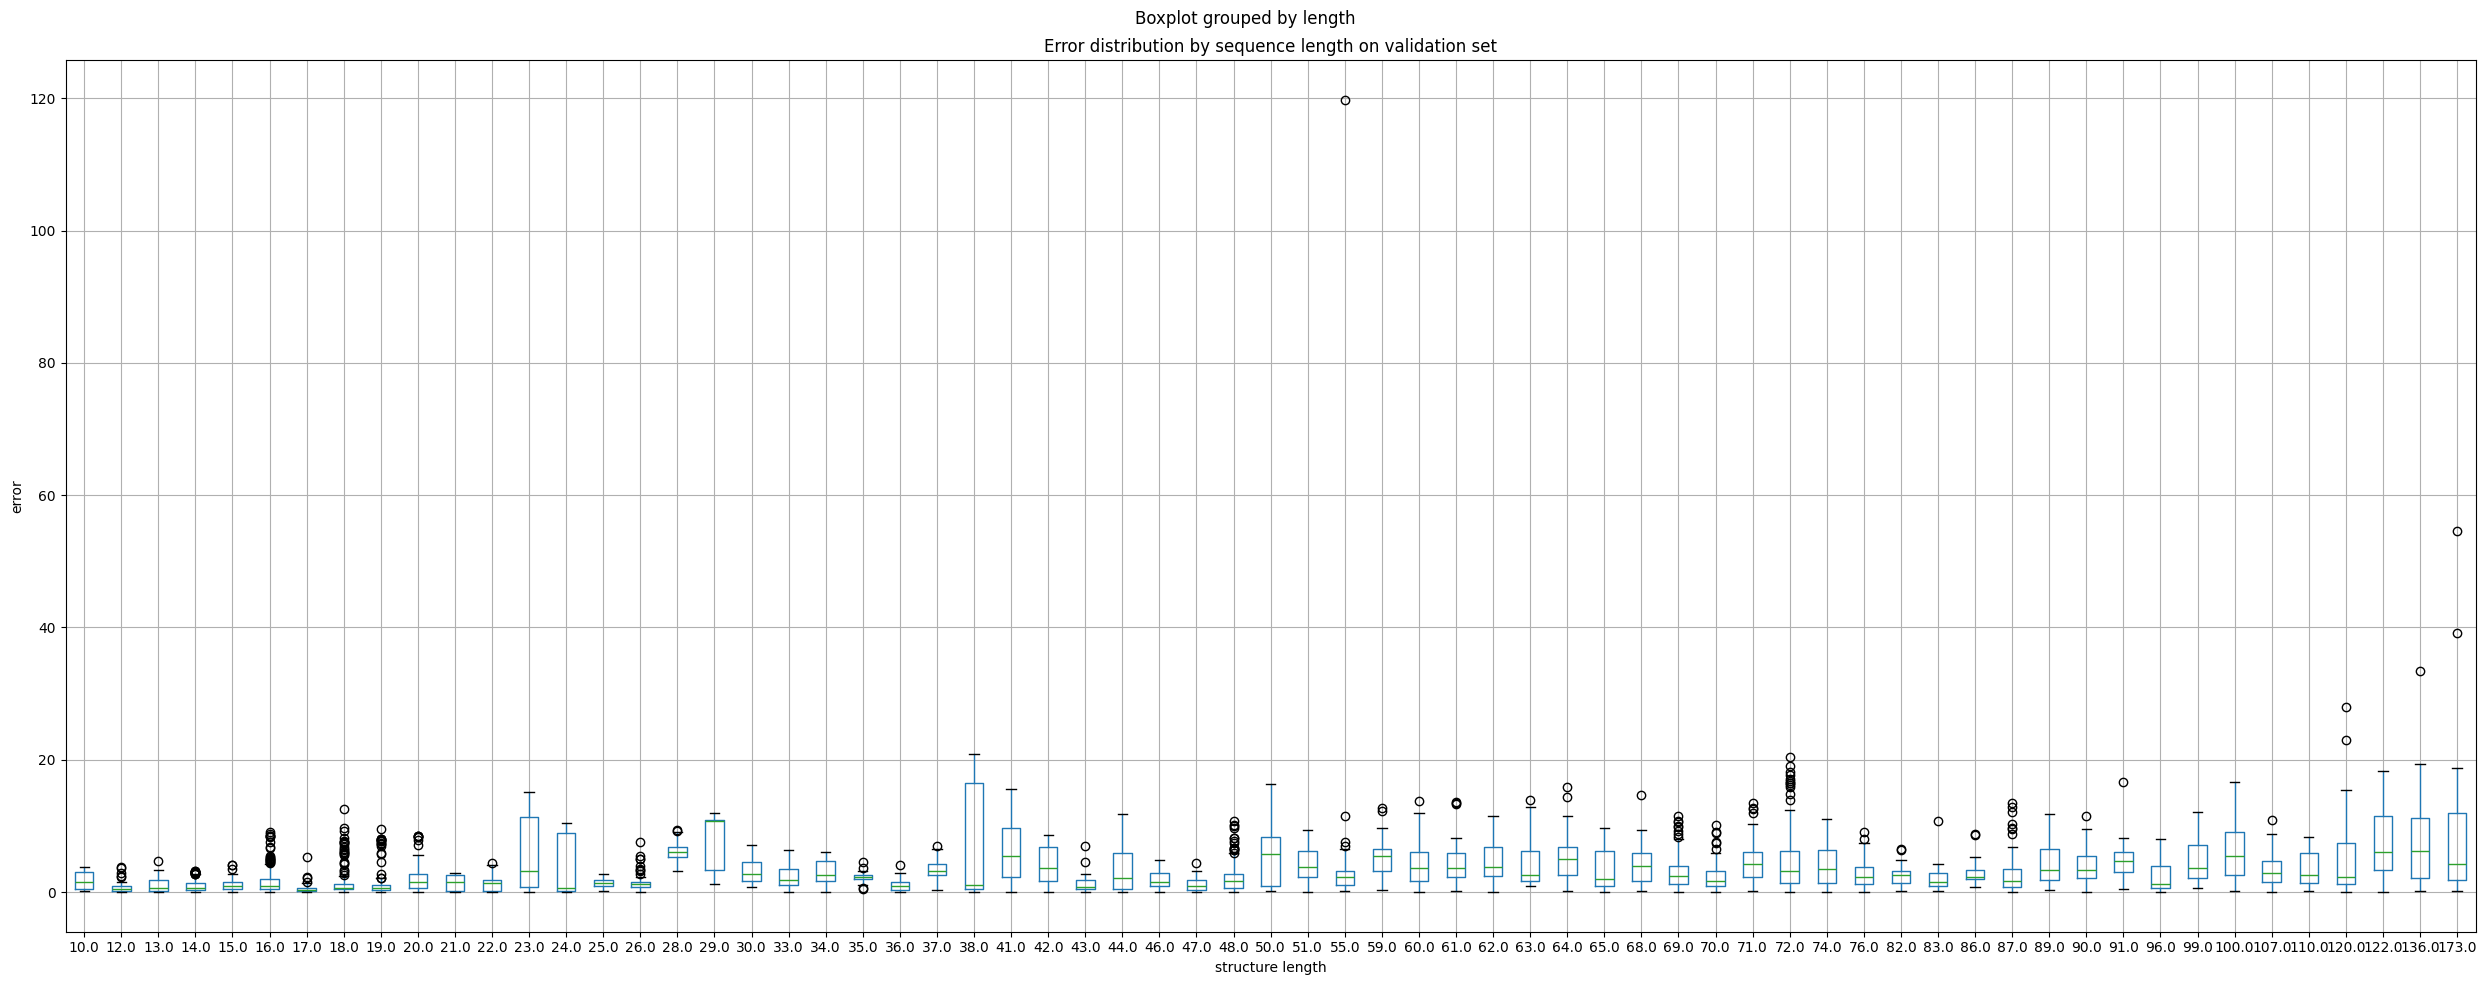

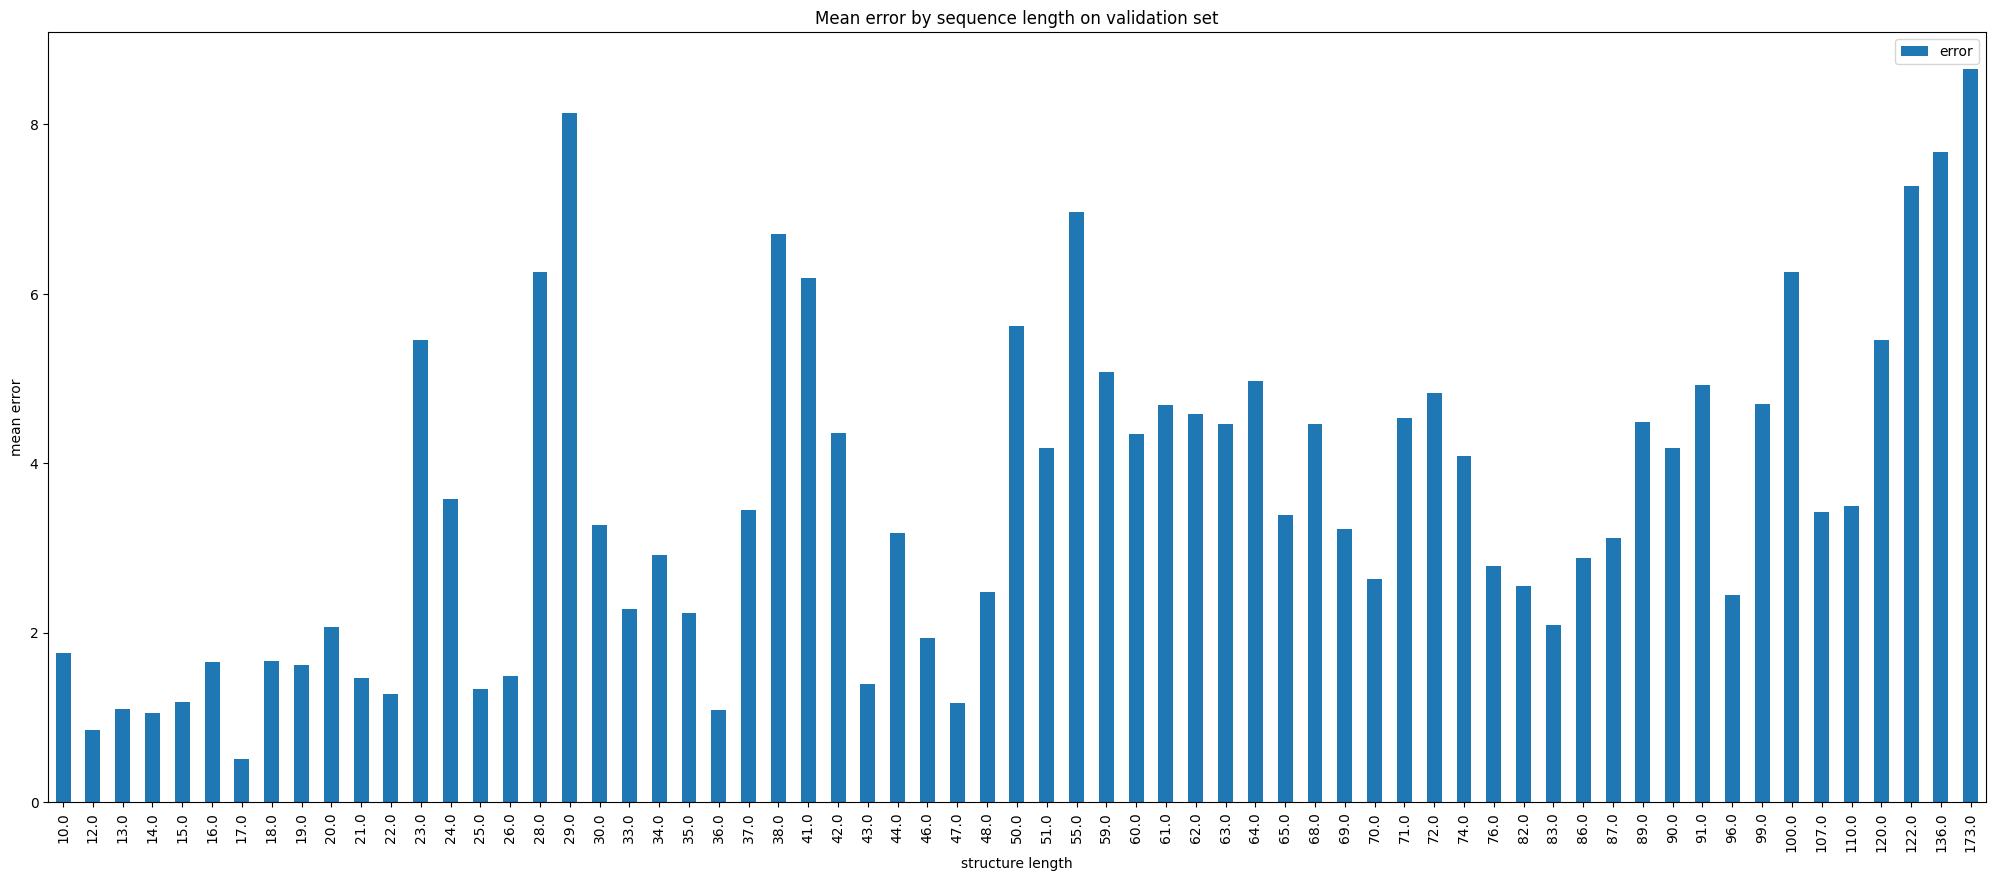

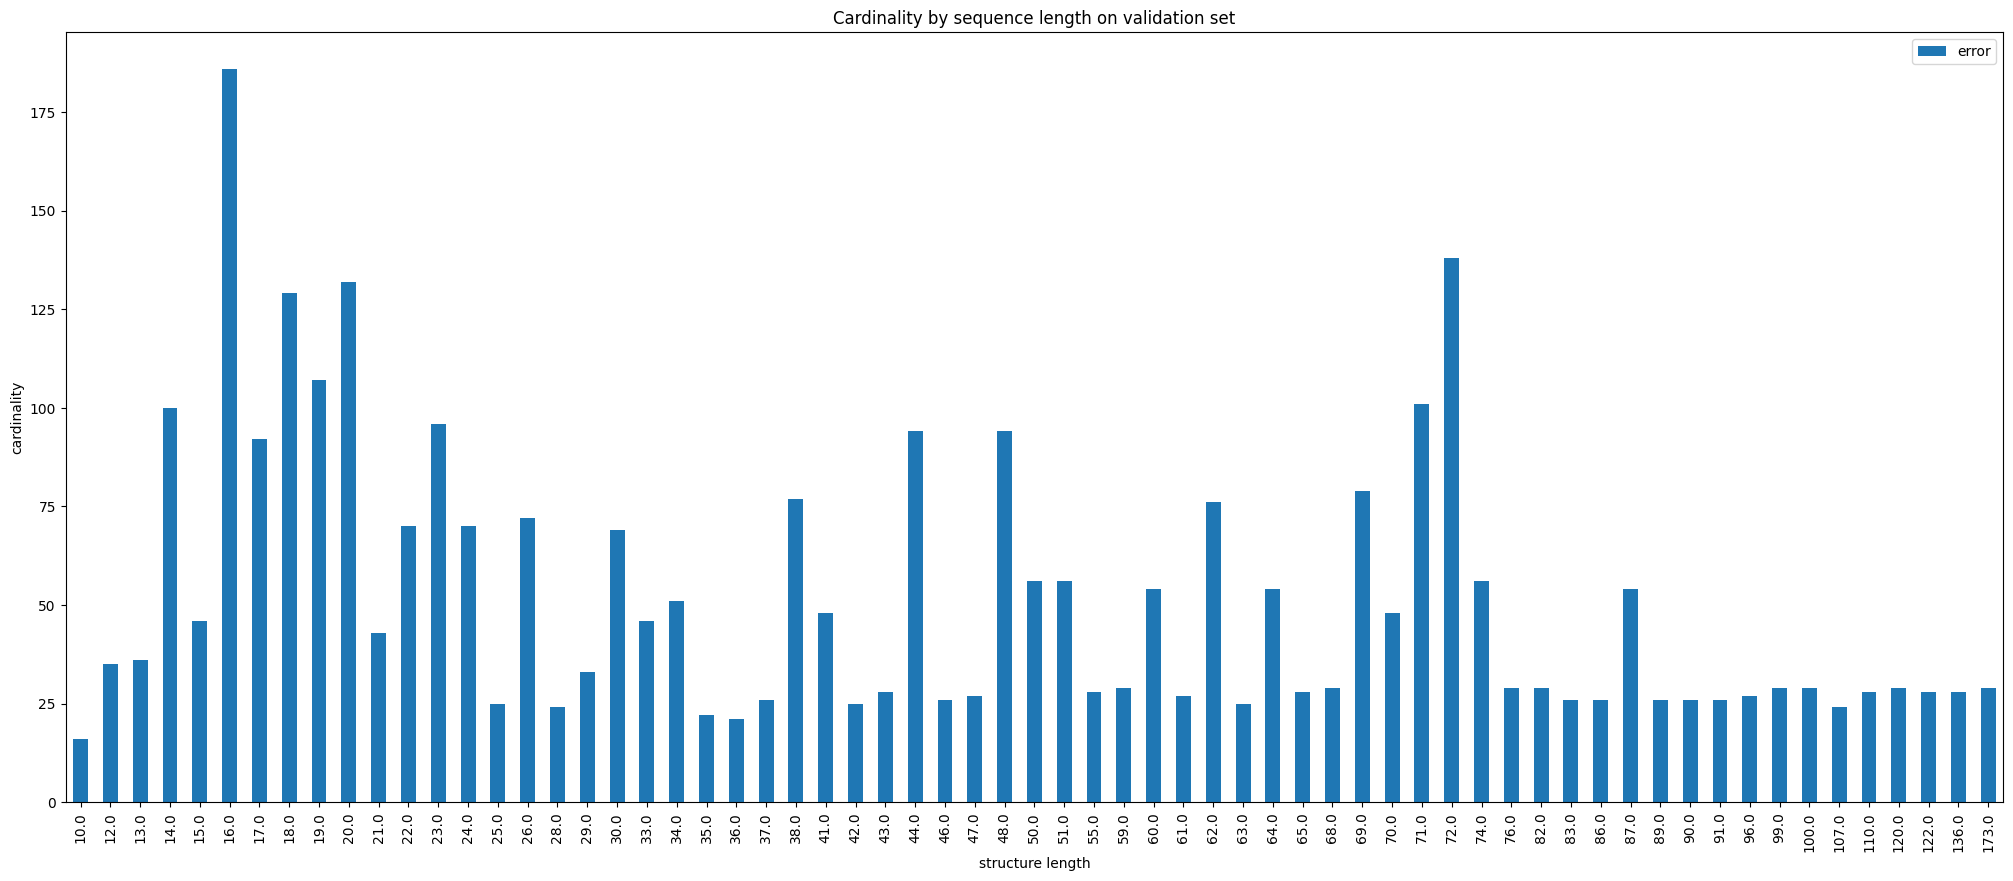

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


UnsupportedNodeError: Lambda aren't supported:
  File "/tmp/ipykernel_417007/2899834813.py", line 66
        # (b, n, num_heads * head_channels) to (b, n, num_heads, head_channels)
        qs, ks, vs = map(
            lambda t: t.reshape(B, N, self.heads, self.head_channels),
            ~ <--- HERE
            (qs, ks, vs))
    


In [19]:
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

val_model = RNAQuANet.load_from_checkpoint(
    model_checkpoint.best_model_path,
    number_of_node_features=dataset_train[0].x.shape[1],map_location={"cuda":"cpu"}
)
val_model.eval()
res = []
for i in dataset_val:
    res.append(
        [
            i.x.shape[0],
            float(
                abs(
                    i.y.cpu()
                    - val_model(i.x.cuda(), i.edge_index.cuda(), i.edge_attr.cuda(), torch.zeros(i.x.shape[0],dtype=torch.int64).cuda()).detach().cpu().numpy()
                )
            ),
        ]
    )
df = pd.DataFrame(np.array(res), columns=["length", "error"])
fig, ax = plt.subplots(figsize=(25, 10))

df.boxplot(column="error", by="length", ax=ax)
ax.set_xlabel("structure length")
ax.set_ylabel("error")
ax.set_title("Error distribution by sequence length on validation set")
plt.tight_layout()
mlf_logger.experiment.log_figure(mlf_logger.run_id,fig, "error_distribution_by_length.svg")
plt.show()

fig, ax = plt.subplots(figsize=(25, 10))
df.groupby("length").mean().plot(kind="bar", ax=ax)
ax.set_xlabel("structure length")
ax.set_ylabel("mean error")
ax.set_title("Mean error by sequence length on validation set")
mlf_logger.experiment.log_figure(mlf_logger.run_id,fig, "error_mean_by_length.svg")
plt.show()

fig, ax = plt.subplots(figsize=(25, 10))
df.groupby("length").count().plot(kind="bar", ax=ax)

ax.set_xlabel("structure length")
ax.set_ylabel("cardinality")
ax.set_title("Cardinality by sequence length on validation set")
mlf_logger.experiment.log_figure(mlf_logger.run_id, fig, "cardinality_by_length.svg")
plt.show()

mlf_logger.experiment.log_metric(mlf_logger.run_id,"best_val_loss_mae", model_checkpoint.best_model_score.cpu().tolist())
val_model._trainer = L.Trainer()
m=torch.jit.script(val_model).cuda()
torch.jit.save(m,f"/tmp/{mlf_logger.run_id}.pt")
mlf_logger.experiment.log_artifact(mlf_logger.run_id,
    f"/tmp/{mlf_logger.run_id}.pt",
    artifact_path="model"
)

# mlflow.pytorch.log_model(mlf_logger.run_id, val_model, "models")

In [10]:
a=[('cWW', 10.499176539138674, 10.499, 8.808, 9.714, 2.0, 14.688, 0.174, 0.118, -0.184, 14.158, -3.91, 0.117, -0.185, -0.759, 14.143, -3.966, -0.807), (-1, 10.402325220834044, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 10.724717758523992, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 8.235567132869479, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 8.308150997664885, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 14.947003512410111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 6.1314391459102096, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 5.107520533487846, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 14.531147029742694, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 13.545546463690572, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 11.38013875135097, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 15.096501747093592, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), ('cWW', 11.76769081001026, 11.768, 10.0, 10.675, 2.0, 21.141, 0.498, 0.095, 0.835, -17.136, 12.382, 0.096, 0.835, 1.476, -17.137, 12.38, -3.131), (-1, 14.150143568176256, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 15.40588244794825, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 11.396161502892102, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 4.97811550689616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 15.017566081093166, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 10.492900504626926, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 5.482615160669222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 10.76047680170354, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 10.490161342896494, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (-1, 15.096501747093592, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)]

In [11]:
a[:2]

[('cWW',
  10.499176539138674,
  10.499,
  8.808,
  9.714,
  2.0,
  14.688,
  0.174,
  0.118,
  -0.184,
  14.158,
  -3.91,
  0.117,
  -0.185,
  -0.759,
  14.143,
  -3.966,
  -0.807),
 (-1,
  10.402325220834044,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0)]

In [12]:
[len(i) for i in a]

[18,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 18,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37]

In [13]:
from rnaquanet.pipelines.structure_processing.descriptive_columns import EDGE_FEATURE_COLUMNS
from rnaquanet.pipelines.structure_processing.nodes import parse_bp_type_onehot
import copy
import numpy as np
default_edge_features = [0.0] * len(EDGE_FEATURE_COLUMNS)

default_edge_features = np.array(default_edge_features).astype(np.float32)
edge_attr = np.array(
                [
                    np.concatenate(
                        (
                            parse_bp_type_onehot(
                                bp_f[0], copy.deepcopy(default_edge_features), bp_f[1]
                            ),
                            np.array(bp_f[2:]),
                        )
                    )
                    for bp_f in a
                ]
            )

[02/26/25 22:07:30] INFO     Using                                                                  ]8;id=234053;file:///home/adamczykb/rnaquanet/.venv/lib/python3.13/site-packages/kedro/framework/project/__init__.py\__init__.py]8;;\:]8;id=146316;file:///home/adamczykb/rnaquanet/.venv/lib/python3.13/site-packages/kedro/framework/project/__init__.py#270\270]8;;\
                             '/home/adamczykb/rnaquanet/.venv/lib/python3.13/site-packages/kedro/fr                
                             amework/project/rich_logging.yml' as logging configuration.                           

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:8                                                                                    │
│                                                                                                  │
│    5 default_edge_features = [0.0] * len(EDGE_FEATURE_COLUMNS)                                   │
│    6                                                                                             │
│    7 default_edge_features = np.array(default_edge_features).astype(np.float32)                  │
│ ❱  8 edge_attr = np.array(                                                                       │
│    9 │   │   │   │   [                                                                           │
│   10 │   │   │   │   │   np.concatenate(                                                         │
│   11 │   │   │   │   │   │   (                                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 
dimensions. The detected shape was (23,) + inhomogeneous part.